In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

from os import listdir
from os.path import join
from numpy import array
import cv2

import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor

from ignite.contrib.handlers import ProgressBar

from functools import partial
from ignite.engine import Engine, Events, _prepare_batch
from ignite.engine import create_supervised_evaluator
from ignite.metrics import RunningAverage, Loss
from ignite.metrics.confusion_matrix import (
    ConfusionMatrix,
    mIoU, IoU,
    DiceCoefficient,
    cmAccuracy,
)

In [2]:
torch.set_grad_enabled(False)
cv2.setNumThreads(0)

In [3]:
def create_segmentation_evaluator(
    model,
    device,
    num_classes=19,
    loss_fn=None,
    non_blocking=True
):

    cm = partial(ConfusionMatrix, num_classes)

    metrics = {
        'iou': IoU(cm()),
        'miou': mIoU(cm()),
        'accuracy': cmAccuracy(cm()),
        'dice': DiceCoefficient(cm()),
    }

    if loss_fn is not None:
        metrics['loss'] = Loss(loss_fn)

    evaluator = create_supervised_evaluator(
        model,
        metrics,
        device,
        non_blocking=non_blocking,
    )

    return evaluator

In [4]:
class AveiroDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        images_dir = join(root_dir, 'images')
        labels_dir = join(root_dir, 'labels')

        def generate_examples(images_dir, labels_dir):
            images = listdir(images_dir)
            images = [join(images_dir, image) for image in images]
            images = sorted(images)
            labels = listdir(labels_dir)
            labels = [join(labels_dir, image) for image in labels]
            labels = sorted(labels)

            assert len(images) == len(labels)

            for image, label in zip(images, labels):
                yield {
                    'image': image,
                    'label': label,
                }

        self.examples = list(generate_examples(images_dir, labels_dir))
        self.transforms = transforms
    
    def __getitem__(self, index):
        o = self.examples[index]

        image = o['image']
        label = o['label']

        image = cv2.imread(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

        if self.transforms is not None:
            out = self.transforms(image=image, mask=label)
            return out['image'], out['mask'].long()
        else:
            return image, label

    def __len__(self):
        return len(self.examples)

In [5]:
device = torch.device('cuda:3')
#device = torch.device('cpu')
val_tfms = albu.Compose([albu.Normalize(),albu.CenterCrop(640,1280),ToTensor()])

In [6]:
ds = AveiroDataset('', transforms=val_tfms)

In [7]:
val_loader = DataLoader(ds, batch_size=1, shuffle=False, drop_last=False)

In [8]:
model = torch.hub.load('bernardomig/neural', 'contextnet14', config='bdd100k-2x')
modelcity = torch.hub.load('bernardomig/neural', 'contextnet14', config='cityscapes-2x')
#model = torch.hub.load('bernardomig/neural', 'deeplabv2_resnet18', config='bdd100k')
model = model.to(device).eval()
modelcity = modelcity.to(device).eval()

evaluator = create_segmentation_evaluator(model, device, num_classes=19)
evaluatorcity = create_segmentation_evaluator(modelcity, device, num_classes=19)

ProgressBar().attach(evaluator)
ProgressBar().attach(evaluatorcity)

Using cache found in /home/rubencosta/.cache/torch/hub/bernardomig_neural_master
Using cache found in /home/rubencosta/.cache/torch/hub/bernardomig_neural_master


In [9]:
state = evaluator.run(val_loader)
statecity = evaluatorcity.run(val_loader)

/home/rubencosta/miniconda3/envs/torch/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [10]:
state.metrics['iou'][[0,1,13]].mean()

tensor(0.8226, dtype=torch.float64)

In [11]:
state.metrics['iou']

tensor([0.9148, 0.6065, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.9465, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], dtype=torch.float64)

# VISUALIZE MODEL OUTPUTS

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

def create_cityscapes_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[:19, :] = np.array([
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [70, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]])
    return ListedColormap(colormap / 255., N=256)

cmap = create_cityscapes_colormap()

In [13]:
ds = AveiroDataset('')

In [59]:
id = 37

In [60]:
img, lbl = ds[id]
img = img[:640, :, :]
o = val_tfms(image=img)
x = o['image']
batch = torch.stack([x])

y = model(batch.cuda(3)).cpu()
ycity = modelcity(batch.cuda(3)).cpu()
#y = model(batch).cpu()

classes = torch.argmax(y,dim=1)[0]
classescity = torch.argmax(ycity,dim=1)[0]

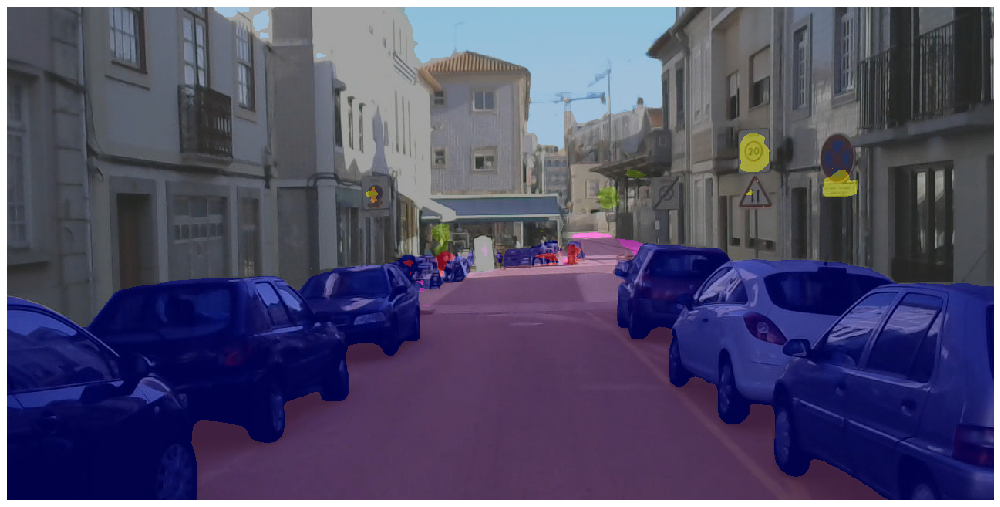

In [61]:
alpha = 0.5

fig, ax = plt.subplots(1,1, figsize=(14, 24))
ax.set_axis_off()
#ax[0].imshow(img)
#ax[1].imshow(cmap(classes))
ax.imshow(alpha * img.astype('float') / 255 + (1-alpha) * cmap(classes)[..., :3])
fig.tight_layout()
plt.savefig('bdd100k-37.png')

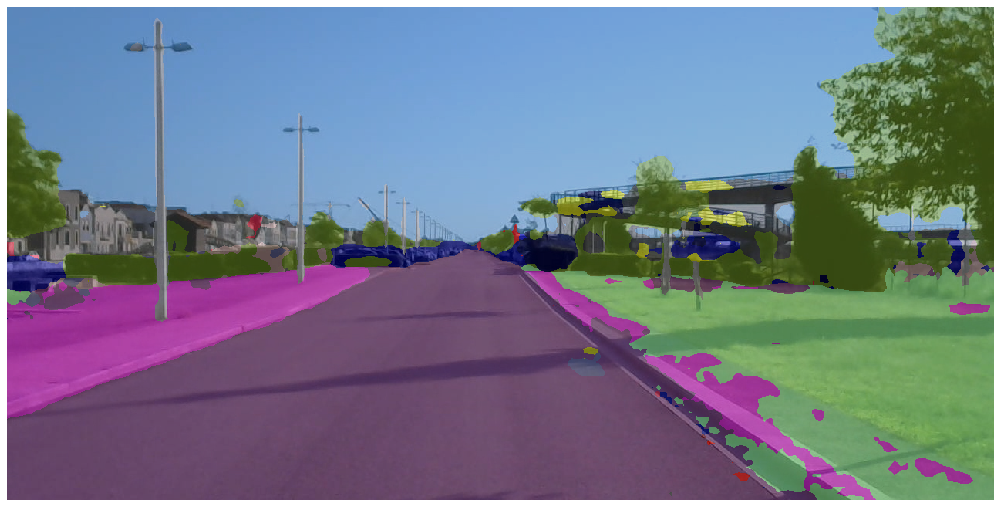

In [49]:
alpha = 0.5

fig, ax = plt.subplots(1,1, figsize=(14, 24))
ax.set_axis_off()
#ax[0].imshow(img)
#ax[1].imshow(cmap(classescity))
ax.imshow(alpha * img.astype('float') / 255 + (1-alpha) * cmap(classescity)[..., :3])
plt.axis('off')
fig.axes[0]
#fig.axes.get_xaxis().set_visible(False)
#fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('cityscapes-25.png')

